In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier,StackingClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE,ADASYN


In [2]:
bank=pd.read_csv('Customer-Churn-Records.csv',index_col=0)
bank.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
RowNumber,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [3]:
X=bank.drop(['CustomerId','Surname','Exited'],axis=1)
y=bank.Exited

In [4]:
X_dum=pd.get_dummies(X,drop_first=True)
X_dum.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
RowNumber,,,,,,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,2,464,0,0,0,0,0,0
2,608,41,1,83807.86,1,0,1,112542.58,1,3,456,0,1,0,0,0,0
3,502,42,8,159660.80,3,1,0,113931.57,1,3,377,0,0,0,0,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,5,350,0,0,0,1,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,5,425,0,1,0,1,0,0


In [70]:
X.shape

(10000, 14)

# Random Forest

In [28]:
rf=RandomForestClassifier(random_state=23,oob_score=True,n_estimators=100)
params={"max_features":np.arange(2,12)}
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=23)
gcv=GridSearchCV(rf,cv=kfold,param_grid=params,scoring="neg_log_loss")
gcv.fit(X_dum,y)
print("best para=",gcv.best_params_)
print("best score=",gcv.best_score_)

best para= {'max_features': 5}
best score= -0.01728936751647599


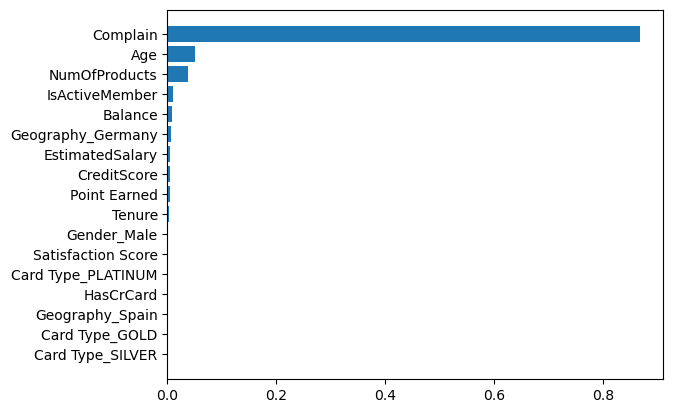

In [30]:
best_tree=gcv.best_estimator_
df_imp=pd.DataFrame({'features':X_dum.columns,'importance':best_tree.feature_importances_})
df_imp=df_imp.sort_values(by='importance')
plt.barh(df_imp['features'],df_imp['importance'])
plt.show()

# Light GBM

In [35]:
lgb=LGBMClassifier(random_state=23)

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 23,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [38]:
params={'learning_rate':np.linspace(0.001,0.8,10),
        'max_depth':[2,3,5,6,None],
        'n_estimators':[50,100,150]}
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=23)
gcv=GridSearchCV(lgb,cv=kfold,scoring='neg_log_loss',param_grid=params)
gcv.fit(X_dum,y)
print(gcv.best_params_)
print(gcv.best_score_)

{'learning_rate': 0.08977777777777779, 'max_depth': 2, 'n_estimators': 100}
-0.010117974834652033


# Stacking

In [5]:
scaler=MinMaxScaler()
lr=LogisticRegression()
svm=SVC(probability=True,random_state=23)
dtc=DecisionTreeClassifier(random_state=23)
xg=XGBClassifier(random_state=23)

In [6]:
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=23)
stacking=StackingClassifier([('LR',lr),('SVM',svm),('TREE',dtc)],final_estimator=xg,passthrough=True)


In [7]:
pipe=Pipeline([('SC',scaler),('st',stacking)])

In [10]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [60]:
params={'st__LR__penalty':['l1','l2','elasticnet',None],
        'st__SVM__C':[0.01,2,5],
        'st__SVM__gamma':[0.01,2,5],
        'st__TREE__max_depth':[None,4,5],
        'st__TREE__min_samples_split':[2,5,10],
        'st__TREE__min_samples_leaf':[1,5,10],
        'st__final_estimator__learning_rate':np.linspace(0.001,0.8,10),
        'st__final_estimator__max_depth':[2,3,5,6,7,8,None],
        'st__final_estimator__n_estimators':[50,100,150]}
gcv=RandomizedSearchCV(pipe,param_distributions=params,cv=kfold,scoring='neg_log_loss',random_state=23,n_iter=15,n_jobs=-1)
gcv.fit(X_dum,y)

C:\Users\dai\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dai\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dai\AppData\Local\anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dai\AppData\Local\anaconda3\lib\site-packages\sklearn\ensemble\_stacking.py", line 660, in fit
    return 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=Pipeline(steps=[('SC', MinMaxScaler()),
                                             ('st',
                                              StackingClassifier(estimators=[('LR',
                                                                              LogisticRegression()),
                                                                             ('SVM',
                                                                              SVC(probability=True,
                                                                                  random_state=23)),
                                                                             ('TREE',
                                                                              DecisionTreeClassifier(random_state=23))],
                                                                 final_estimator=XGBClassifier(base_score=None,
                                                                                               booster=None,
                                                                                               cal...
                                        'st__TREE__min_samples_leaf': [1, 5,
                                                                       10],
                                        'st__TREE__min_samples_split': [2, 5,
                                                                        10],
                                        'st__final_estimator__learning_rate': array([0.001     , 0.08977778, 0.17855556, 0.26733333, 0.35611111,
       0.44488889, 0.53366667, 0.62244444, 0.71122222, 0.8       ]),
                                        'st__final_estimator__max_depth': [2, 3,
                                                                           5, 6,
                                                                           7, 8,
                                                                           None],
                                        'st__final_estimator__n_estimators': [50,
                                                                              100,
                                                                              150]},
                   random_state=23, scoring='neg_log_loss')

In [65]:
print(gcv.best_params_)
print(gcv.best_score_)

{'st__final_estimator__n_estimators': 100, 'st__final_estimator__max_depth': None, 'st__final_estimator__learning_rate': 0.26733333333333337, 'st__TREE__min_samples_split': 5, 'st__TREE__min_samples_leaf': 10, 'st__TREE__max_depth': 5, 'st__SVM__gamma': 5, 'st__SVM__C': 5, 'st__LR__penalty': None}
-0.011620075437218375


# voting

In [83]:
import warnings
warnings.filterwarnings("ignore")

lr = LogisticRegression()
dtc = DecisionTreeClassifier(random_state=23)
nb = GaussianNB()

voting = VotingClassifier([("Lr",lr),
                           ('TREE',dtc),
                           ('NB',nb)], voting='soft',n_jobs=-1,verbose=2)

kfold=StratifiedKFold(n_splits=5,random_state=23,shuffle=True)


In [85]:
params={"TREE__max_depth":[None,3,5],
        "TREE__min_samples_split":[2,5,10],
        "TREE__min_samples_leaf":[1,5,10],
        "Lr__penalty":['l1','l2','elasticnet',None]       
       }
gcv=RandomizedSearchCV(voting,param_distributions=params,cv=kfold,scoring='neg_log_loss',random_state=23,n_iter=15,n_jobs=-1)
gcv.fit(X_dum,y)
print(gcv.best_params_)
print(gcv.best_score_)

{'TREE__min_samples_split': 2, 'TREE__min_samples_leaf': 10, 'TREE__max_depth': 3, 'Lr__penalty': 'l2'}
-0.23314507789599132


# SMOTE

In [87]:
bank['Exited'].value_counts(normalize=True)*100

0    79.62
1    20.38
Name: Exited, dtype: float64

In [88]:
smote=SMOTE(random_state=23)
X_smote,y_smote=smote.fit_resample(X_dum,y)
print("X_smote.shape=",X_smote.shape,"y_smote.shape=",y_smote.shape)
print(y_smote.value_counts())
print(y_smote.value_counts(normalize=True)*100)

X_smote.shape= (15924, 17) y_smote.shape= (15924,)
1    7962
0    7962
Name: Exited, dtype: int64
1    50.0
0    50.0
Name: Exited, dtype: float64


# random forest with smote

In [93]:
rf=RandomForestClassifier(random_state=23,oob_score=True,n_estimators=100)
params={"max_features":np.arange(2,12)}
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=23)
gcv=GridSearchCV(rf,cv=kfold,param_grid=params,scoring="neg_log_loss")
gcv.fit(X_smote,y_smote)
print("best para=",gcv.best_params_)
print("best score=",gcv.best_score_)

best para= {'max_features': 7}
best score= -0.012361635295487583


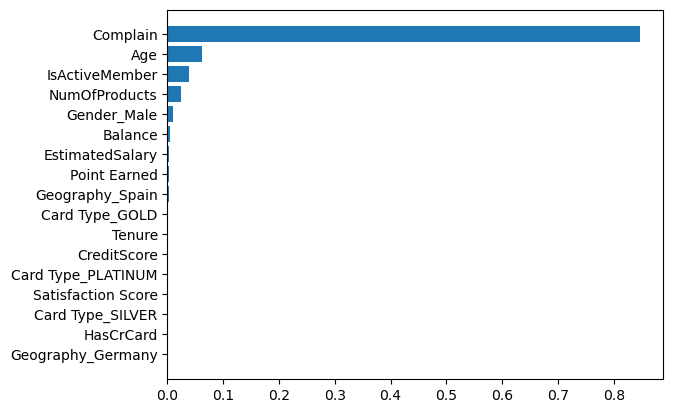

In [94]:
best_tree=gcv.best_estimator_
df_imp=pd.DataFrame({'features':X_smote.columns,'importance':best_tree.feature_importances_})
df_imp=df_imp.sort_values(by='importance')
plt.barh(df_imp['features'],df_imp['importance'])
plt.show()

# Light GBM with SMOTE

In [95]:
lgb=LGBMClassifier(random_state=23)
params={'learning_rate':np.linspace(0.001,0.8,10),
        'max_depth':[2,3,5,6,None],
        'n_estimators':[50,100,150]}
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=23)
gcv=GridSearchCV(lgb,cv=kfold,scoring='neg_log_loss',param_grid=params)
gcv.fit(X_smote,y_smote)
print(gcv.best_params_)
print(gcv.best_score_)

{'learning_rate': 0.17855555555555558, 'max_depth': 3, 'n_estimators': 100}
-0.008205924098938649


# stacking

In [96]:
scaler=MinMaxScaler()
lr=LogisticRegression()
svm=SVC(probability=True,random_state=23)
dtc=DecisionTreeClassifier(random_state=23)
xg=XGBClassifier(random_state=23)

In [97]:
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=23)
stacking=StackingClassifier([('LR',lr),('SVM',svm),('TREE',dtc)],final_estimator=xg,passthrough=True)
pipe=Pipeline([('SC',scaler),('st',stacking)])

In [99]:
params={'st__LR__penalty':['l1','l2','elasticnet',None],
        'st__SVM__C':[0.01,2,5],
        'st__SVM__gamma':[0.01,2,5],
        'st__TREE__max_depth':[None,4,5],
        'st__TREE__min_samples_split':[2,5,10],
        'st__TREE__min_samples_leaf':[1,5,10],
        'st__final_estimator__learning_rate':np.linspace(0.001,0.8,10),
        'st__final_estimator__max_depth':[2,3,5,6,7,8,None],
        'st__final_estimator__n_estimators':[50,100,150]}
gcv=RandomizedSearchCV(pipe,param_distributions=params,cv=kfold,scoring='neg_log_loss',random_state=23,n_iter=15,n_jobs=-1)
gcv.fit(X_smote,y_smote)
print(gcv.best_params_)
print(gcv.best_score_)

{'st__final_estimator__n_estimators': 100, 'st__final_estimator__max_depth': None, 'st__final_estimator__learning_rate': 0.26733333333333337, 'st__TREE__min_samples_split': 5, 'st__TREE__min_samples_leaf': 10, 'st__TREE__max_depth': 5, 'st__SVM__gamma': 5, 'st__SVM__C': 5, 'st__LR__penalty': None}
-0.009333747018371894


# Voting

In [100]:
import warnings
warnings.filterwarnings("ignore")

lr = LogisticRegression()
dtc = DecisionTreeClassifier(random_state=23)
nb = GaussianNB()

voting = VotingClassifier([("Lr",lr),
                           ('TREE',dtc),
                           ('NB',nb)], voting='soft',n_jobs=-1,verbose=2)

kfold=StratifiedKFold(n_splits=5,random_state=23,shuffle=True)


In [101]:
params={"TREE__max_depth":[None,3,5],
        "TREE__min_samples_split":[2,5,10],
        "TREE__min_samples_leaf":[1,5,10],
        "Lr__penalty":['l1','l2','elasticnet',None]       
       }
gcv=RandomizedSearchCV(voting,param_distributions=params,cv=kfold,scoring='neg_log_loss',random_state=23,n_iter=15,n_jobs=-1)
gcv.fit(X_dum,y)
print(gcv.best_params_)
print(gcv.best_score_)

{'TREE__min_samples_split': 2, 'TREE__min_samples_leaf': 10, 'TREE__max_depth': 3, 'Lr__penalty': 'l2'}
-0.23314507789599132
